## **Final Project: The goal of this project is to classify a product label given a summary of a bug ticket.** 

#### **Purpose of this notebook:** Using this notebook we will be able to preprocess the dataset, explore it, and towards the end, pick the very best model for our final application.

#### **Regarding the dataset:** It was manually collected from bugzilla [1]. Each csv consists of issues of different products from Mozilla. These products include, firefox, seamonkey, thunderbird, and calendar.

#### **Datasets:**  firefox-issues.csv [2], seamonkey-issues.csv [3], thunderbird-issues.csv [4], and calendar-issues.csv [5]
#### **Product Info:**
#### **FireFox:** Firefox browser or Mozilla Firefox web browser.
#### **SeaMonkey:** All-in one internet application suite which powers Thunderbird and many other Mozilla products. 
#### **ThunderBird:** An email client by Mozilla.
#### **Calendar:** Cross-platform calendar application by Mozilla.

#### **Note:** Each csv belongs a specific product, and that is why we have 4 different products. Later, we will have to combine them all into one dataframe with their associated target variables (i.e product name) 

[1] https://bugzilla.mozilla.org/query.cgi?classification=Client%20Software&product=Firefox&query_format=advanced&resolution=---  <br>
[2] https://bugzilla.mozilla.org/buglist.cgi?classification=Client%20Software&product=Firefox&query_format=advanced&resolution=---&order=bug_status%2Cpriority%2Cassigned_to%2Cbug_id&limit=0&ctype=csv&human=1 <br>
[3] https://bugzilla.mozilla.org/buglist.cgi?classification=Client%20Software&product=SeaMonkey&query_format=advanced&resolution=---&order=bug_status%2Cpriority%2Cassigned_to%2Cbug_id&limit=0&ctype=csv&human=1 <br>
[4] https://bugzilla.mozilla.org/buglist.cgi?classification=Client%20Software&product=Thunderbird&query_format=advanced&resolution=---&order=bug_status%2Cpriority%2Cassigned_to%2Cbug_id&limit=0&ctype=csv&human=1 <br>
[5] https://bugzilla.mozilla.org/buglist.cgi?classification=Client%20Software&product=Calendar&query_format=advanced&resolution=---&order=bug_status%2Cpriority%2Cassigned_to%2Cbug_id&limit=0&ctype=csv&human=1

In [115]:
#Necesary downloads
!pip install contractions

In [116]:
#Imports and downloads
import pandas as pd
import contractions
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import string
import matplotlib.pyplot as plt
import re
import seaborn as sns
import warnings
import numpy as np
import keras

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.externals import joblib
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [117]:
#Filenames
INPUT_FILES = ['firefox', 'seamonkey', 'thunderbird', 'calendar']

In [118]:
#Hold each datasets in a dictionary
dfs = {}
for filename in INPUT_FILES:
  key = filename.split('-')[0] 
  dfs[key] = pd.read_csv(filename+"-issues.csv", header=0, usecols=['Summary'])

In [119]:
#Print shape and head of each dataset
def print_each_product_head():
  for filename in INPUT_FILES:
    print(filename)
    print(dfs[filename].shape)
    print(dfs[filename].head())
    print()

print_each_product_head()

firefox
(10000, 1)
                                             Summary
0         Firefox 68.1.0 ESR language change problem
1  right click context menu displaying in first s...
2  Global sharing indicator blocks access to menu...
3                      show tab favicons immediately
4                     Icon looks pixelated on gnome3

seamonkey
(3422, 1)
                                             Summary
0  Missing option "text encoding Unicode/UTF-8" i...
1    Stopgap solution for Multilingual Release Notes
2  Detected Junkmails (automatic or manual) will ...
3  Picture truncated at the top because shifted u...
4  Use secure communication HTTPS for Seamonkey h...

thunderbird
(7874, 1)
                                             Summary
0  Export recursively whole message folder tree a...
1  Non-us letters in profile path causes address ...
2  grouped by sort - the starred list does not st...
3  Thunderbird updater keeps asking to update (ev...
4  Raspberry Pi Buster takes 10 minu

Before doing any pre-preocessing, we will merge all the datasets into 1 dataframe with their associated target variables (i.e. product name)

In [120]:
#Lets first add a target column to each dataset
for filename in INPUT_FILES:
  dfs[filename]['target'] = filename
print_each_product_head()

firefox
(10000, 2)
                                             Summary   target
0         Firefox 68.1.0 ESR language change problem  firefox
1  right click context menu displaying in first s...  firefox
2  Global sharing indicator blocks access to menu...  firefox
3                      show tab favicons immediately  firefox
4                     Icon looks pixelated on gnome3  firefox

seamonkey
(3422, 2)
                                             Summary     target
0  Missing option "text encoding Unicode/UTF-8" i...  seamonkey
1    Stopgap solution for Multilingual Release Notes  seamonkey
2  Detected Junkmails (automatic or manual) will ...  seamonkey
3  Picture truncated at the top because shifted u...  seamonkey
4  Use secure communication HTTPS for Seamonkey h...  seamonkey

thunderbird
(7874, 2)
                                             Summary       target
0  Export recursively whole message folder tree a...  thunderbird
1  Non-us letters in profile path causes address 

In [121]:
#Append all dataframe into 1
all_products = pd.concat(dfs, ignore_index=True)
all_products = all_products.sample(frac=1, random_state=5).reset_index(drop=True)
all_products.rename(columns={"Summary": "summary"}, inplace=True)
all_products.head()

,summary,target
0,Event view selector has no effect with presenc...,calendar
1,Each app should run in a separate process (Sho...,seamonkey
2,Upgrade dependency from redux 3.6.0 / react-re...,firefox
3,"When a link opens in a new tab, back button sh...",firefox
4,mark contact/email as obsolete/dead/404 / abil...,thunderbird


## Preprocessing

In [9]:
#use this function to see the word count of summary column
def count(s = ''):
    print('Word count ' + s +': ' + str(all_products["summary"].str.split().str.len().sum()))
count()

Word count : 252278


In [10]:
#Checkout shape
all_products.shape

(23315, 2)

In [11]:
#Checkout count and other information
all_products.describe()

,summary,target
count,23315,23315
unique,23306,4
top,Message headers don't scroll with the message,firefox
freq,2,10000


Remove any rows with missing values

In [12]:
all_products = all_products.dropna()
all_products.shape
#Size is still same so that is good

(23315, 2)

Remove Contractions

In [13]:
all_products['no_contract'] = all_products['summary'].apply(lambda x: [contractions.fix(word) for word in x.split()])
all_products.head()

,summary,target,no_contract
0,Event view selector has no effect with presenc...,calendar,"[Event, view, selector, has, no, effect, with,..."
1,Each app should run in a separate process (Sho...,seamonkey,"[Each, app, should, run, in, a, separate, proc..."
2,Upgrade dependency from redux 3.6.0 / react-re...,firefox,"[Upgrade, dependency, from, redux, 3.6.0, /, r..."
3,"When a link opens in a new tab, back button sh...",firefox,"[When, a, link, opens, in, a, new, tab,, back,..."
4,mark contact/email as obsolete/dead/404 / abil...,thunderbird,"[mark, contact/email, as, obsolete/dead/404, /..."


In [14]:
#Join no contracted into a string. Replace summary with the no contracted string and delete no_contract
count('Before')
all_products['summary'] = [' '.join(map(str, l)) for l in all_products['no_contract']]
all_products = all_products.drop(['no_contract'], axis=1)
count('After')
all_products.head()

Word count Before: 252278
Word count After: 254278


,summary,target
0,Event view selector has no effect with presenc...,calendar
1,Each app should run in a separate process (Sho...,seamonkey
2,Upgrade dependency from redux 3.6.0 / react-re...,firefox
3,"When a link opens in a new tab, back button sh...",firefox
4,mark contact/email as obsolete/dead/404 / abil...,thunderbird


## Tokenize

In [15]:
all_products['tokenized'] = all_products['summary'].apply(word_tokenize)
all_products.head()

,summary,target,tokenized
0,Event view selector has no effect with presenc...,calendar,"[Event, view, selector, has, no, effect, with,..."
1,Each app should run in a separate process (Sho...,seamonkey,"[Each, app, should, run, in, a, separate, proc..."
2,Upgrade dependency from redux 3.6.0 / react-re...,firefox,"[Upgrade, dependency, from, redux, 3.6.0, /, r..."
3,"When a link opens in a new tab, back button sh...",firefox,"[When, a, link, opens, in, a, new, tab, ,, bac..."
4,mark contact/email as obsolete/dead/404 / abil...,thunderbird,"[mark, contact/email, as, obsolete/dead/404, /..."


## Noise cleaning using tokenized column - Special Characters, Spacing and Lowercasing 

In [16]:
#Convert to lowercase
all_products['lower'] = all_products['tokenized'].apply(lambda x: [word.lower() for word in x])
all_products.head()

,summary,target,tokenized,lower
0,Event view selector has no effect with presenc...,calendar,"[Event, view, selector, has, no, effect, with,...","[event, view, selector, has, no, effect, with,..."
1,Each app should run in a separate process (Sho...,seamonkey,"[Each, app, should, run, in, a, separate, proc...","[each, app, should, run, in, a, separate, proc..."
2,Upgrade dependency from redux 3.6.0 / react-re...,firefox,"[Upgrade, dependency, from, redux, 3.6.0, /, r...","[upgrade, dependency, from, redux, 3.6.0, /, r..."
3,"When a link opens in a new tab, back button sh...",firefox,"[When, a, link, opens, in, a, new, tab, ,, bac...","[when, a, link, opens, in, a, new, tab, ,, bac..."
4,mark contact/email as obsolete/dead/404 / abil...,thunderbird,"[mark, contact/email, as, obsolete/dead/404, /...","[mark, contact/email, as, obsolete/dead/404, /..."


Remove punctuation

In [17]:
punc = string.punctuation
all_products['no_punc'] = all_products['lower'].apply(lambda x: [word for word in x if word not in punc])
all_products.head()

,summary,target,tokenized,lower,no_punc
0,Event view selector has no effect with presenc...,calendar,"[Event, view, selector, has, no, effect, with,...","[event, view, selector, has, no, effect, with,...","[event, view, selector, has, no, effect, with,..."
1,Each app should run in a separate process (Sho...,seamonkey,"[Each, app, should, run, in, a, separate, proc...","[each, app, should, run, in, a, separate, proc...","[each, app, should, run, in, a, separate, proc..."
2,Upgrade dependency from redux 3.6.0 / react-re...,firefox,"[Upgrade, dependency, from, redux, 3.6.0, /, r...","[upgrade, dependency, from, redux, 3.6.0, /, r...","[upgrade, dependency, from, redux, 3.6.0, reac..."
3,"When a link opens in a new tab, back button sh...",firefox,"[When, a, link, opens, in, a, new, tab, ,, bac...","[when, a, link, opens, in, a, new, tab, ,, bac...","[when, a, link, opens, in, a, new, tab, back, ..."
4,mark contact/email as obsolete/dead/404 / abil...,thunderbird,"[mark, contact/email, as, obsolete/dead/404, /...","[mark, contact/email, as, obsolete/dead/404, /...","[mark, contact/email, as, obsolete/dead/404, a..."


Remove stop words

In [18]:
stop_words = set(stopwords.words('english'))
all_products['no_stopwords'] = all_products['no_punc'].apply(lambda x: [word for word in x if word not in stop_words])
all_products.head()

,summary,target,tokenized,lower,no_punc,no_stopwords
0,Event view selector has no effect with presenc...,calendar,"[Event, view, selector, has, no, effect, with,...","[event, view, selector, has, no, effect, with,...","[event, view, selector, has, no, effect, with,...","[event, view, selector, effect, presence, non,..."
1,Each app should run in a separate process (Sho...,seamonkey,"[Each, app, should, run, in, a, separate, proc...","[each, app, should, run, in, a, separate, proc...","[each, app, should, run, in, a, separate, proc...","[app, run, separate, process, able, start, ``,..."
2,Upgrade dependency from redux 3.6.0 / react-re...,firefox,"[Upgrade, dependency, from, redux, 3.6.0, /, r...","[upgrade, dependency, from, redux, 3.6.0, /, r...","[upgrade, dependency, from, redux, 3.6.0, reac...","[upgrade, dependency, redux, 3.6.0, react-redu..."
3,"When a link opens in a new tab, back button sh...",firefox,"[When, a, link, opens, in, a, new, tab, ,, bac...","[when, a, link, opens, in, a, new, tab, ,, bac...","[when, a, link, opens, in, a, new, tab, back, ...","[link, opens, new, tab, back, button, availabl..."
4,mark contact/email as obsolete/dead/404 / abil...,thunderbird,"[mark, contact/email, as, obsolete/dead/404, /...","[mark, contact/email, as, obsolete/dead/404, /...","[mark, contact/email, as, obsolete/dead/404, a...","[mark, contact/email, obsolete/dead/404, abili..."


Lemmatize

In [19]:
wnl = WordNetLemmatizer()
all_products['lemmatized'] = all_products['no_stopwords'].apply(lambda x: [wnl.lemmatize(word) for word in x])
all_products.head()

,summary,target,tokenized,lower,no_punc,no_stopwords,lemmatized
0,Event view selector has no effect with presenc...,calendar,"[Event, view, selector, has, no, effect, with,...","[event, view, selector, has, no, effect, with,...","[event, view, selector, has, no, effect, with,...","[event, view, selector, effect, presence, non,...","[event, view, selector, effect, presence, non,..."
1,Each app should run in a separate process (Sho...,seamonkey,"[Each, app, should, run, in, a, separate, proc...","[each, app, should, run, in, a, separate, proc...","[each, app, should, run, in, a, separate, proc...","[app, run, separate, process, able, start, ``,...","[app, run, separate, process, able, start, ``,..."
2,Upgrade dependency from redux 3.6.0 / react-re...,firefox,"[Upgrade, dependency, from, redux, 3.6.0, /, r...","[upgrade, dependency, from, redux, 3.6.0, /, r...","[upgrade, dependency, from, redux, 3.6.0, reac...","[upgrade, dependency, redux, 3.6.0, react-redu...","[upgrade, dependency, redux, 3.6.0, react-redu..."
3,"When a link opens in a new tab, back button sh...",firefox,"[When, a, link, opens, in, a, new, tab, ,, bac...","[when, a, link, opens, in, a, new, tab, ,, bac...","[when, a, link, opens, in, a, new, tab, back, ...","[link, opens, new, tab, back, button, availabl...","[link, open, new, tab, back, button, available..."
4,mark contact/email as obsolete/dead/404 / abil...,thunderbird,"[mark, contact/email, as, obsolete/dead/404, /...","[mark, contact/email, as, obsolete/dead/404, /...","[mark, contact/email, as, obsolete/dead/404, a...","[mark, contact/email, obsolete/dead/404, abili...","[mark, contact/email, obsolete/dead/404, abili..."


Replace summary with lemmatized string and drop all the unnecessary columns

In [20]:
count('before')
all_products['summary'] = [' '.join(map(str, l)) for l in all_products['lemmatized']]
all_products = all_products.drop(['tokenized', 'lower', 'no_punc', 'no_stopwords', 'lemmatized'], axis=1)
count('after')
all_products.head()

Word count before: 254278
Word count after: 183425


,summary,target
0,event view selector effect presence non workin...,calendar
1,app run separate process able start `` task ''...,seamonkey
2,upgrade dependency redux 3.6.0 react-redux 5.0.6,firefox
3,link open new tab back button available return...,firefox
4,mark contact/email obsolete/dead/404 ability d...,thunderbird


Create a Word Cloud of summary

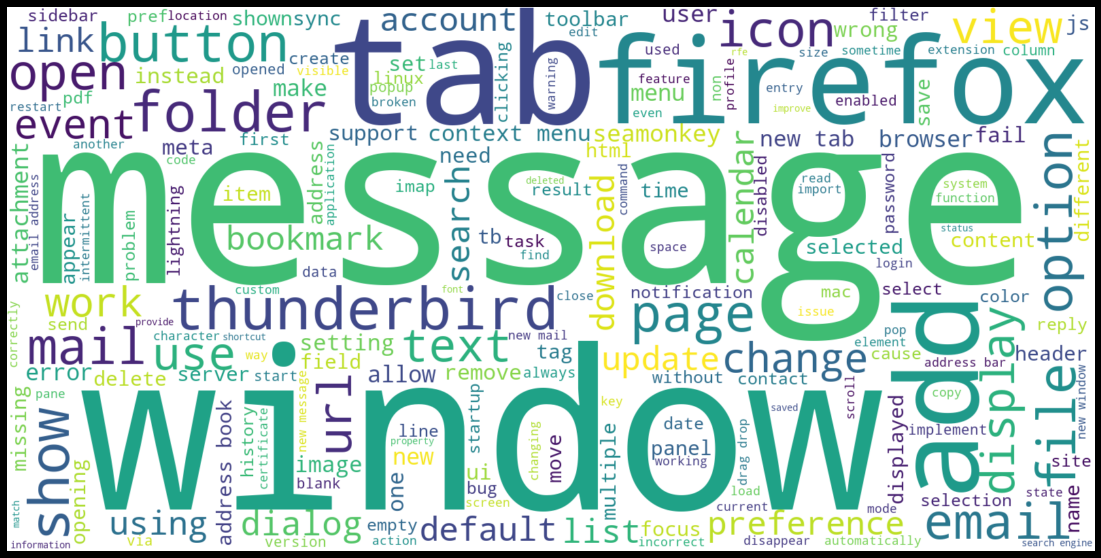

In [21]:
def word_cloud():
  text = ' '.join(summ for summ in all_products.summary)
  wc = WordCloud(background_color="white", width=1600, height=800).generate(text)
  plt.figure( figsize=(20,10), facecolor='k')
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.show()
word_cloud()

In the above word cloud we can see many technical terms, such as view, text, event, menu, ui etc. This visualization is helpful because it gives us some idea of what the dataset is about. The visualization is also giving us a clear picture of which technical terms appear the most times, which gives us a very quick and easy assessment.

In [22]:
all_products.head()

,summary,target
0,event view selector effect presence non workin...,calendar
1,app run separate process able start `` task ''...,seamonkey
2,upgrade dependency redux 3.6.0 react-redux 5.0.6,firefox
3,link open new tab back button available return...,firefox
4,mark contact/email obsolete/dead/404 ability d...,thunderbird


We can still see some special characters. We will remove all of the special characters.

In [23]:
#Remove all special characters except letters, digits and version
def nospecialChar(text):
    text = re.sub("[^a-zA-Z(\d+\.)?(\d+\.)?(\*|\d+)$]+", " ",text)
    return text

In [24]:
#Call noSpecialChar
all_products['no_special'] = all_products['summary'].apply(lambda x: nospecialChar(x))
all_products.head()

,summary,target,no_special
0,event view selector effect presence non workin...,calendar,event view selector effect presence non workin...
1,app run separate process able start `` task ''...,seamonkey,app run separate process able start task diffe...
2,upgrade dependency redux 3.6.0 react-redux 5.0.6,firefox,upgrade dependency redux 3.6.0 react redux 5.0.6
3,link open new tab back button available return...,firefox,link open new tab back button available return...
4,mark contact/email obsolete/dead/404 ability d...,thunderbird,mark contact email obsolete dead 404 ability d...


In the above table, we can see that it still preserves a digit and a version. We might want to preserve these versions because they could add some valuable information to our model. In addition, it removed all the other special characters.

In [25]:
#Replace summary with no_special and drop no_special
count('before')
all_products['summary'] = all_products['no_special']
all_products = all_products.drop(['no_special'], axis=1)
count('after')

Word count before: 183425
Word count after: 186353


In [26]:
all_products.head()

,summary,target
0,event view selector effect presence non workin...,calendar
1,app run separate process able start task diffe...,seamonkey
2,upgrade dependency redux 3.6.0 react redux 5.0.6,firefox
3,link open new tab back button available return...,firefox
4,mark contact email obsolete dead 404 ability d...,thunderbird


Revised word cloud

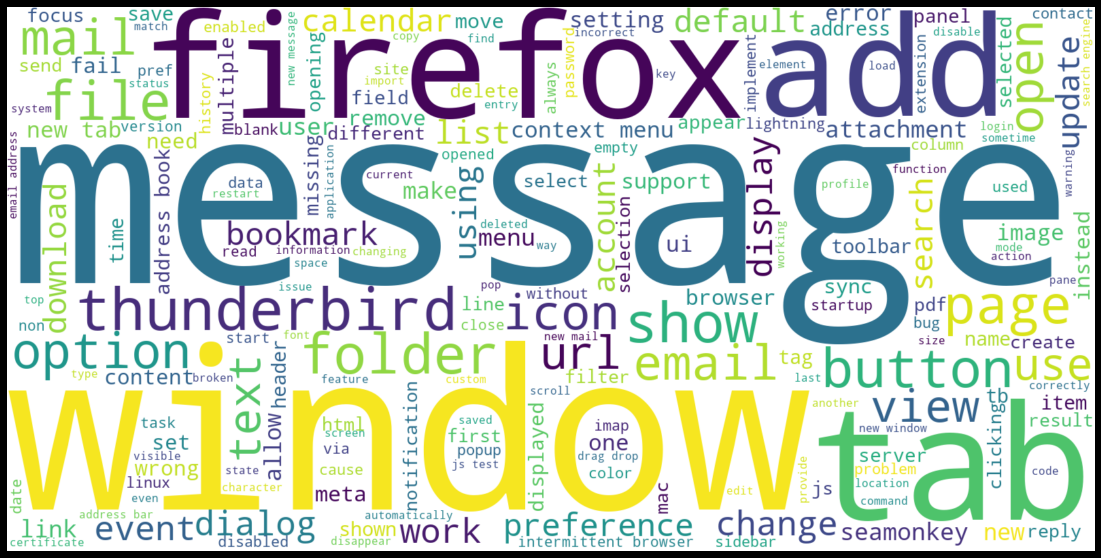

In [27]:
word_cloud()

We don't see much difference compared to the earlier version of the word cloud

Let's visualize summary length and summary word count

In [28]:
#Summary length
all_products['length'] = all_products['summary'].apply(len)
all_products['word_count'] = all_products['summary'].apply(lambda x: len(x.split()))
all_products.head()

,summary,target,length,word_count
0,event view selector effect presence non workin...,calendar,56,8
1,app run separate process able start task diffe...,seamonkey,58,9
2,upgrade dependency redux 3.6.0 react redux 5.0.6,firefox,48,7
3,link open new tab back button available return...,firefox,59,10
4,mark contact email obsolete dead 404 ability d...,thunderbird,81,11


Distribution of summary length and word count

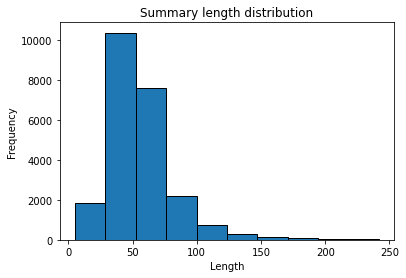

In [29]:
plt.hist(all_products['length'], edgecolor='black')
plt.ylabel('Frequency')
plt.xlabel('Length')
plt.title('Summary length distribution')
plt.show()

In the above distribution, we can see that most summaries fall roughly between the length of 26-51 characters.

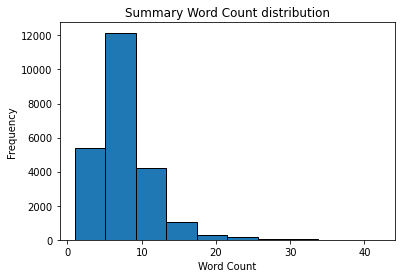

In [30]:
plt.hist(all_products['word_count'], edgecolor='black')
plt.ylabel('Frequency')
plt.xlabel('Word Count')
plt.title('Summary Word Count distribution')
plt.show()

In the above distribution, we can see that most summaries consists of roughly 6-9 words.

Visualize the distribution of target variables or product names

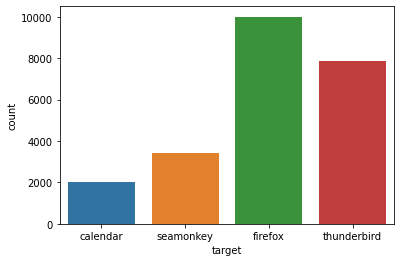

In [31]:
sns.countplot(x = all_products['target'])

We can see that this dataset is highly imbalanced, but before we balance this dataset lets visualize the word count per different product.

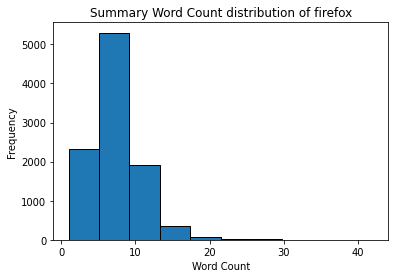

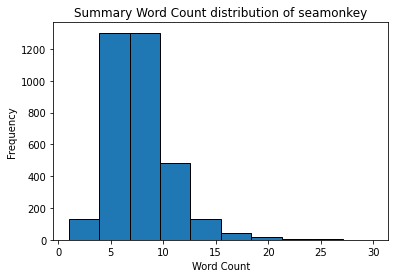

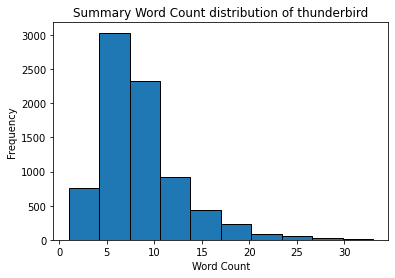

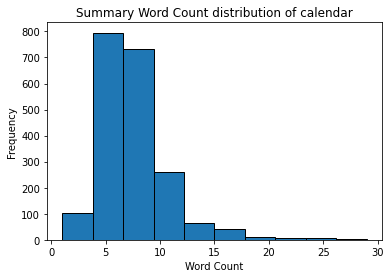

In [32]:
#Go through each target variable and display the distribution
for target_var in INPUT_FILES:
  target_specific = all_products.loc[all_products['target'] == target_var]
  plt.hist(target_specific['word_count'], edgecolor='black')
  plt.ylabel('Frequency')
  plt.xlabel('Word Count')
  plt.title('Summary Word Count distribution of ' + target_var)
  plt.show()

There's not much difference in the word count of summaries from different target variables. We could say each summary word count would be roughly 6 words.

### Uni-gram

To further understand our dataset, we will print out top 10 uni-gram, bi-gram and tri-gram of individual products. 

In [33]:
#Join all summary and call vectorizer fit to learn the vocabulary
uni_grams = pd.DataFrame(columns=['Top ' + str(i+1) for i in range(0,10)], index=INPUT_FILES)
for target_var in INPUT_FILES:
  target_specific = all_products.loc[all_products['target'] == target_var]
  summary_corpus = [' '.join(target_specific.summary)]
  vectorizer = CountVectorizer()
  vec = vectorizer.fit(summary_corpus)
  matrix = vec.transform(summary_corpus)
  counts = matrix.toarray()
  summary_words_freq = [(word, counts[0, idx]) for word, idx in vec.vocabulary_.items()]
  summary_words_freq = sorted(summary_words_freq, key = lambda freq: freq[1], reverse=True)
  top10 = summary_words_freq[:10]
  for idx, word in enumerate(top10):
    uni_grams.at[target_var, 'Top '+str(idx+1)] = word[0]
uni_grams

,Top 1,Top 2,Top 3,Top 4,Top 5,Top 6,Top 7,Top 8,Top 9,Top 10
firefox,tab,firefox,window,browser,page,menu,new,search,bookmark,button
seamonkey,seamonkey,message,window,mail,menu,folder,tab,page,new,add
thunderbird,message,folder,mail,thunderbird,email,window,new,account,address,search
calendar,calendar,event,lightning,task,view,dialog,time,day,caldav,error


We could also plot the uni-gram frequency into a bar plot, but it would be hard to visualize since we have multiple products, and that is why I added top 10 uni-grams into a table.

Above uni-gram table shows terms that are specific to each product,for instance, firefox is more related to browser, page, bookmark and search (all terms related to a browser). We do see a little overlap between seamonkey and thunderbird, it could be because seamonkey powers the thunderbird application, so most of the bugs between them are common. 

### Bi-gram

In [34]:
bi_grams = pd.DataFrame(columns=['Top ' + str(i+1) for i in range(0,10)], index=INPUT_FILES)
for target_var in INPUT_FILES:
  target_specific = all_products.loc[all_products['target'] == target_var]
  vectorizer = CountVectorizer(ngram_range=(2,2), stop_words="english")
  vec = vectorizer.fit(target_specific.summary)
  matrix = vec.transform(target_specific.summary)
  sum_bigrams = matrix.sum(axis=0)
  summary_bigram_freq = [(bigram, sum_bigrams[0, idx]) for bigram, idx in vec.vocabulary_.items()]
  summary_bigram_freq = sorted(summary_bigram_freq, key = lambda freq: freq[1], reverse=True)
  top10 = summary_bigram_freq[:10]
  for idx, word in enumerate(top10):
    bi_grams.at[target_var, 'Top '+str(idx+1)] = word[0]
bi_grams

,Top 1,Top 2,Top 3,Top 4,Top 5,Top 6,Top 7,Top 8,Top 9,Top 10
firefox,new tab,context menu,intermittent browser,address bar,search engine,bookmark toolbar,new window,js test,open new,test timed
seamonkey,context menu,port bug,address book,data manager,web page,menu item,new window,location bar,thread pane,new mail
thunderbird,address book,new message,compose window,new mail,email address,message list,context menu,plain text,imap folder,message header
calendar,today pane,calendar event,recurring event,caldav calendar,event dialog,event task,calendar view,new event,calendar test,google calendar


It is interesting to see how even with the bi-grams there are some overlaps between seamonkey and thunderbird. For instance, "new mail", "web page", and "context menu". After using the bi-gram we get a better picture of what these issues might look like per product.

### Tri-gram

In [35]:
tri_grams = pd.DataFrame(columns=['Top ' + str(i+1) for i in range(0,10)], index=INPUT_FILES)
for target_var in INPUT_FILES:
  target_specific = all_products.loc[all_products['target'] == target_var]
  vectorizer = CountVectorizer(ngram_range=(3,3), stop_words="english")
  vec = vectorizer.fit(target_specific.summary)
  matrix = vec.transform(target_specific.summary)
  sum_trigrams = matrix.sum(axis=0)
  summary_trigram_freq = [(trigram, sum_trigrams[0, idx]) for trigram, idx in vec.vocabulary_.items()]
  summary_trigram_freq = sorted(summary_trigram_freq, key = lambda freq: freq[1], reverse=True)
  top10 = summary_trigram_freq[:10]
  for idx, word in enumerate(top10):
    tri_grams.at[target_var, 'Top '+str(idx+1)] = word[0]
tri_grams

,Top 1,Top 2,Top 3,Top 4,Top 5,Top 6,Top 7,Top 8,Top 9,Top 10
firefox,js test timed,new tab page,open new tab,add automated test,intermittent browser components,browser base content,base content test,private browsing mode,open new window,intermittent e10s browser
seamonkey,particular web page,open new tab,new mail notification,location bar autocomplete,reference undefined property,amo browsing seamonkey,clear private data,right click menu,mochitest browser chrome,context menu item
thunderbird,intermittent comm mail,comm mail test,mail test browser,new mail notification,js uncaught exception,test unexpected fail,chrome messenger content,quick filter bar,message compose window,test browser composition
calendar,comm calendar test,calendar test browser,intermittent comm calendar,day week view,invite attendee dialog,test browser browser,event task dialog,calendar event dialog,modification failed error,test unexpected fail


After applying tri-gram, we barely see any overlaps between the products. Issues get more specific per product and it makes sense because we are adding more terms.

### Split the dataset before handling imbalanced dataset

(23315, 4)


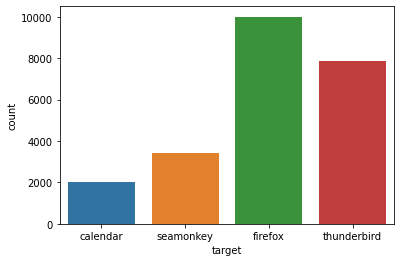

In [36]:
print(all_products.shape)
sns.countplot(x = all_products['target'])

As mentioned earlier, we have a highly imbalanced dataset. So to fix this issue, we will over-sample the minority classes. In this case, it would be calendar, seamonkey and thunderbird. However, before we over-sample, we have to split our train and test set, because we want to avoid leaking any synthetic data to the test set. If we don't split now, then our model might give us better performance because it has already seen the synthetic data, and this would be incorrect. Now, in order to split the dataset we will first calculate TF-IDFs. 

In [37]:
#TF-Idf calculation
vector = TfidfVectorizer(stop_words='english')
tfidf = vector.fit_transform(all_products['summary'])
#Dump the vector for later
joblib_tfidf_vector = "tfidf_vector.pkl"
joblib.dump(vector, joblib_tfidf_vector)
tfidf = tfidf.toarray()
words = vector.get_feature_names()
tfidf_df = pd.DataFrame(tfidf, columns=words)
print(tfidf_df.shape)
tfidf

(23315, 12005)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [38]:
index = tfidf[0].argmax()
print("value: " + str(tfidf[0][index]))
words[(tfidf[0]).argmax()]

value: 0.5213994308951302


'presence'

In [39]:
all_products['summary'][0]

'event view selector effect presence non working calendar'

For the purpose of splitting, we will use 20% for testing and 80% for training.

In [40]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_df, all_products['target'], test_size = 0.2, random_state=1)

In [41]:
print("Train shape: " + str(x_train.shape))
print("Test shape: " + str(x_test.shape))

Train shape: (18652, 12005)
Test shape: (4663, 12005)


Now, let's check out the actual distribution of the target variable in the training set.

(18652,)


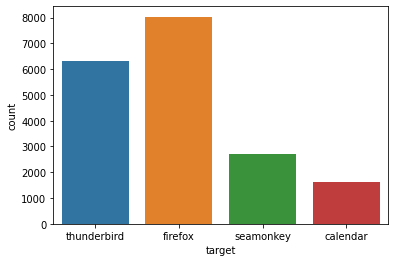

In [42]:
print(y_train.shape)
sns.countplot(x = y_train)

Clearly, the training set is still not balanced. Therefore, we will apply SMOTE (Synthetic Minority Over-Sampling Technique) to generate more synthetic samples for the minority classes. In this case, thunderbird, seamonkey and calendar are the minority classes. The SMOTE package itself is implemented for binary classification. Since we have 3 classes to balance, we will run this algorithm 3 times, and each time it runs, it will over-sample the minority class. https://imbalanced-learn.org/stable/over_sampling.html

### Balance training dataset

In [43]:
#Ignore future warning so we can see the print statements clearly 
warnings.simplefilter(action='ignore', category=FutureWarning)
print("Before: " + str(x_train.shape))
smt = SMOTE(random_state=3, sampling_strategy='minority')
# Over Sample: Calendar
x_smote, y_smote = smt.fit_sample(x_train, y_train)
print("After over sampling calendar: " + str(x_smote.shape))
# Over Sample: Seamonkey
x_smote, y_smote = smt.fit_sample(x_smote, y_smote)
print("After over sampling seamonkey: " + str(x_smote.shape))
# Over Sample: Thunderbird
x_smote, y_smote = smt.fit_sample(x_smote, y_smote)
print("After over sampling thunderbird: " + str(x_smote.shape))
print("Final shape: " + str(x_smote.shape))

Before: (18652, 12005)
After over sampling calendar: (25080, 12005)
After over sampling seamonkey: (30396, 12005)
After over sampling thunderbird: (32128, 12005)
Final shape: (32128, 12005)


Now we can see that there's an increase in the number of training sample. Let's again plot the distribution of the target variables.

(32128,)


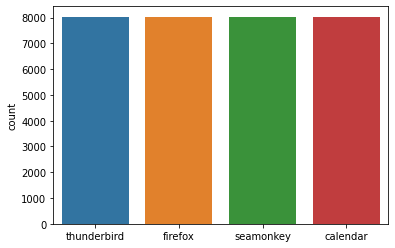

In [44]:
print(y_smote.shape)
sns.countplot(x = y_smote)

Finally, our training dataset is fully balanced. We can now pass x_smote and y_smote to different models.

### Models

### Naive Bayes

In [89]:
#classify using Naive Bayes
clf_nb = MultinomialNB()
clf_nb.fit(x_smote, y_smote)
y_predict = clf_nb.predict(x_test)
clf_nb_acc_score = accuracy_score(y_test, y_predict)
clf_nb_classification_report = pd.DataFrame()
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

    calendar       0.74      0.92      0.82       415
     firefox       0.85      0.79      0.81      1968
   seamonkey       0.46      0.56      0.50       706
 thunderbird       0.79      0.74      0.76      1574

    accuracy                           0.75      4663
   macro avg       0.71      0.75      0.73      4663
weighted avg       0.76      0.75      0.75      4663



In [91]:
unique_label = np.unique([y_test, y_predict])
cmtx = pd.DataFrame(metrics.confusion_matrix(y_test, y_predict, labels=unique_label), 
    index=['true:{:}'.format(x) for x in unique_label], 
    columns=['pred:{:}'.format(x) for x in unique_label]
)
print(cmtx)

                  pred:calendar  pred:firefox  pred:seamonkey  pred:thunderbird
true:calendar               380            10               9                16
true:firefox                 42          1545             242               139
true:seamonkey               25           135             395               151
true:thunderbird             64           137             216              1157


In [92]:
joblib_multinomial_nb = "joblib_multinomial_nb_model.pkl"
joblib.dump(clf_nb, joblib_multinomial_nb)

['joblib_multinomial_nb_model.pkl']

In [93]:
multinomial_nb = joblib.load(joblib_multinomial_nb)
new_question = "Unable to open bookmarks using middle click when connected to single monitor"
tfidf_vectorizer = joblib.load(joblib_tfidf_vector)
vectorized_question = tfidf_vectorizer.transform([new_question])
multinomial_nb.predict(vectorized_question)

array(['firefox'], dtype='<U11')

### Decision Tree

In [94]:
#Classify using decision tree
clf_dt = tree.DecisionTreeClassifier()
clf_dt.fit(x_smote, y_smote)
y_predict = clf_dt.predict(x_test)
clf_dt_acc_score = accuracy_score(y_test, y_predict)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

    calendar       0.84      0.82      0.83       415
     firefox       0.77      0.82      0.79      1968
   seamonkey       0.43      0.39      0.41       706
 thunderbird       0.75      0.72      0.73      1574

    accuracy                           0.72      4663
   macro avg       0.70      0.69      0.69      4663
weighted avg       0.72      0.72      0.72      4663



In [96]:
unique_label = np.unique([y_test, y_predict])
cmtx = pd.DataFrame(metrics.confusion_matrix(y_test, y_predict, labels=unique_label), 
    index=['true:{:}'.format(x) for x in unique_label], 
    columns=['pred:{:}'.format(x) for x in unique_label]
)
print(cmtx)

                  pred:calendar  pred:firefox  pred:seamonkey  pred:thunderbird
true:calendar               339            34              10                32
true:firefox                 20          1613             161               174
true:seamonkey               15           237             276               178
true:thunderbird             31           215             193              1135


In [97]:
joblib_decision_tree_model = "joblib_decision_tree_model.pkl"
joblib.dump(clf_dt, joblib_decision_tree_model)

['joblib_decision_tree_model.pkl']

### Random Forest

In [98]:
clf_rf = RandomForestClassifier(n_estimators=40, max_depth=10)
clf_rf.fit(x_smote, y_smote)
y_predict = clf_rf.predict(x_test)
clf_rf_acc_score = accuracy_score(y_test, y_predict)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

    calendar       0.72      0.81      0.76       415
     firefox       0.71      0.85      0.78      1968
   seamonkey       0.48      0.37      0.42       706
 thunderbird       0.80      0.67      0.73      1574

    accuracy                           0.71      4663
   macro avg       0.68      0.67      0.67      4663
weighted avg       0.71      0.71      0.71      4663



In [99]:
unique_label = np.unique([y_test, y_predict])
cmtx = pd.DataFrame(metrics.confusion_matrix(y_test, y_predict, labels=unique_label), 
    index=['true:{:}'.format(x) for x in unique_label], 
    columns=['pred:{:}'.format(x) for x in unique_label]
)
print(cmtx)

                  pred:calendar  pred:firefox  pred:seamonkey  pred:thunderbird
true:calendar               336            52              10                17
true:firefox                 51          1677             147                93
true:seamonkey               21           279             259               147
true:thunderbird             57           343             121              1053


In [100]:
joblib_random_forest_model = "joblib_random_forest_model.pkl"
joblib.dump(clf_rf, joblib_random_forest_model)

['joblib_random_forest_model.pkl']

### Logistic Regression

In [102]:
clf_lr = LogisticRegression(random_state=10, solver='lbfgs', max_iter=1000)
clf_lr.fit(x_smote, y_smote)
y_predict = clf_lr.predict(x_test)
clf_lr_acc_score = accuracy_score(y_test, y_predict)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

    calendar       0.89      0.83      0.86       415
     firefox       0.81      0.87      0.84      1968
   seamonkey       0.50      0.52      0.51       706
 thunderbird       0.81      0.75      0.78      1574

    accuracy                           0.77      4663
   macro avg       0.75      0.74      0.75      4663
weighted avg       0.77      0.77      0.77      4663



In [103]:
unique_label = np.unique([y_test, y_predict])
cmtx = pd.DataFrame(metrics.confusion_matrix(y_test, y_predict, labels=unique_label), 
    index=['true:{:}'.format(x) for x in unique_label], 
    columns=['pred:{:}'.format(x) for x in unique_label]
)
print(cmtx)

                  pred:calendar  pred:firefox  pred:seamonkey  pred:thunderbird
true:calendar               346            33              12                24
true:firefox                  8          1705             160                95
true:seamonkey                7           184             365               150
true:thunderbird             26           172             197              1179


In [104]:
joblib_logistic_regression_model = "joblib_logistic_regression_model.pkl"
joblib.dump(clf_lr, joblib_logistic_regression_model)

['joblib_logistic_regression_model.pkl']

In [122]:
lr_model = joblib.load(joblib_logistic_regression_model)
new_question = "Unable to open bookmarks using middle click when connected to single monitor"
tfidf_vectorizer = joblib.load(joblib_tfidf_vector)
vectorized_question = tfidf_vectorizer.transform([new_question])
lr_model.predict(vectorized_question)

array(['firefox'], dtype=object)

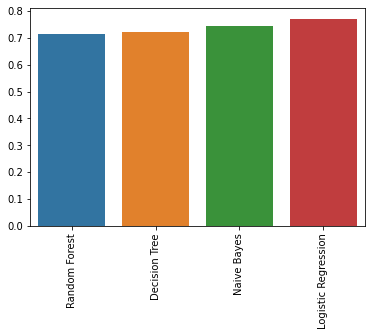

In [113]:
x = ['Random Forest','Decision Tree', 'Naive Bayes', 'Logistic Regression']
y = [clf_rf_acc_score, clf_dt_acc_score, clf_nb_acc_score,clf_lr_acc_score]

plot = sns.barplot(x, y)
plt.setp(plot.get_xticklabels(), rotation=90)
plt.show()

If we compare the accuracy of each of the models, we come to the conclusion that Logistic Regression has the highest accuracy and Random Forest has the worst accuracy. In this case, we can rely on the accuracy because we have balanced our dataset. If we compare the  f1-score of seamonkey between the models, they are not the best. Most of the predictions for seamonkey are getting distributed between firefox and thunderbird. As we saw earlier, the uni-grams and the bi-grams between thunderbird and seamonkey had many common terms and this could be one of the reasons why the dominant classes like firefox and thunderbird are incorrectly getting classified instead of seamonkey.

For the purpose of this project, we will use "joblib_logistic_regression_model.pkl" and "tf-idf_vector.pkl" to create a console application where a user can type a description of a ticket and the model will predict a product label. Ideally, this whole process should be integrated in some type of a service or a pipeline where every support ticket would go through the prediction stage, and then based on the predicted product label, it would add the support ticket into its appropriate queue for the maintenance team.